In [39]:
from metadata import *
from utils_cnn import *
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


In [40]:
# Check if GPU is available:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Data transforms

In [41]:
# Create a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, id_dict, transform=None, interval = [], binarize = False):
        self.transform = transform
        self.image_paths = [id_dict[id]['preprocessed'] for id in id_dict.keys()]
        self.scores = [id_dict[id]['score'] for id in id_dict.keys()]
        
        # if bins is not empty, then we want to binarize the scores
        if len(interval) != 0 and binarize == True:
            # Binarize the scores:
            for i in range(len(self.scores)):
                # iterate over "scores" and assign "i" to the self.scores that are in the interval[i][0] and interval[i][1] range:
                for j in range(len(interval)):
                    if self.scores[i] >= interval[j][0] and self.scores[i] <= interval[j][1]:
                        self.scores[i] = j
                        break
        # "else" case is non-empty interval and binarize = False, which means we want to keep the scores as they are
        
        
    def __len__(self):
        return len(self.scores)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = nib.load(img_path).get_fdata()
        label = self.scores[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def get_data(data_transforms, batch_size, num_workers, interval = [], binarize = False):
    
    # Get only a dataset for a specific interval
    mtd = DatasetMetadata( 'ImaGenoma', 'T1_b', interval = interval)
    IDs = mtd.IDs
    id_dict = mtd.id_dict
    
    # Read the id_dict[id][score] list and split it into train, val, and test sets:
    
    
    
    whole_dataset =  CustomImageDataset(id_dict, transform=data_transforms, interval=interval, binarize=binarize)
    splits = ['train', 'val', 'test']
    
    len_train, len_val = [round(.6 * len(whole_dataset)), round(.2 * len(whole_dataset))]
    len_test = len(whole_dataset) - len_train - len_val
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        whole_dataset, [len_train, len_val, len_test], generator=torch.Generator().manual_seed(0))

    datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in splits}
    
    return dataloaders, mtd, IDs, id_dict

In [42]:
# load MNI image
MNI_PATH = '../data/datasets/_MNI_template/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii'
mni = nib.load(MNI_PATH).get_fdata()
mni_mean, mni_std = [mni.mean(), mni.std()]

center_crop = 200
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mni_mean, mni_std, inplace=False),
])

### Check the balancing of the subset and splits

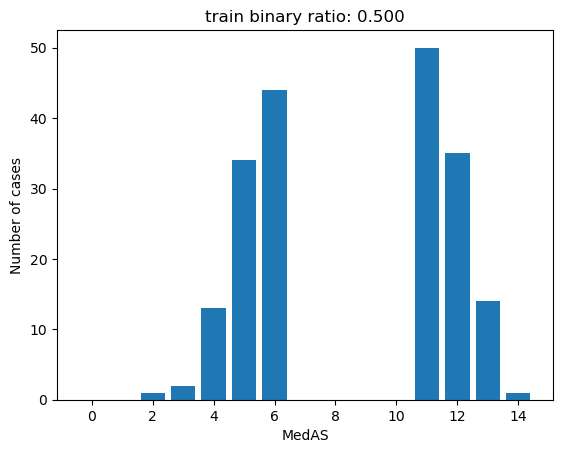

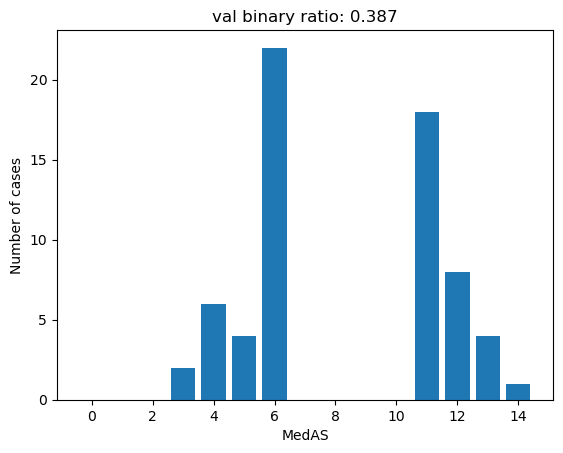

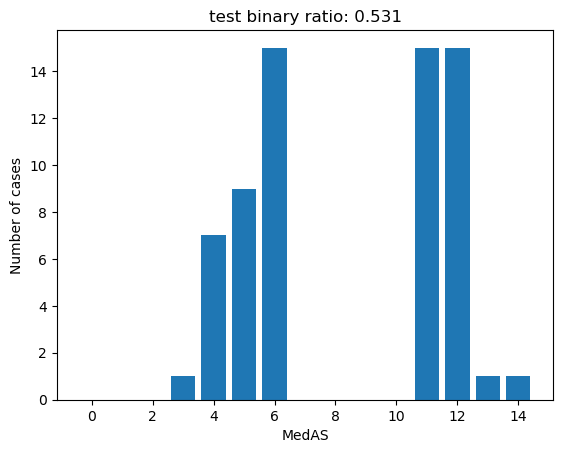

In [43]:
dataloaders, mtd, IDs, id_dict = get_data(data_transforms, batch_size = 4, num_workers = 2, interval = [[0, 6], [11, 14]], binarize = False)

# count the number of elements of each class in the training set
splits = ['train', 'val', 'test']

split_classes = {}
for split in splits:
    class_count = np.zeros(15)
    for data in dataloaders[split]:
        inputs, labels = data
        for i in range(len(labels)):
            class_count[int(labels[i])] += 1
    split_classes[split] = class_count
    # sum the elements of the first 6 classes
    split_classes[split + '_binary_ratio'] = np.sum(class_count[:6])/np.sum(class_count[7:])

# print a histogram of the number of elements of each class in the training set
for split in splits:
    plt.figure()
    plt.title(split + ' binary ratio: %.3f' % split_classes[split + '_binary_ratio'])
    plt.bar(np.arange(15), split_classes[split])
    plt.xlabel('MedAS')
    plt.ylabel('Number of cases')
    plt.show()
    

### Binary data loading

In [4]:
# Hyperparameters
batch_size = 4
num_workers = 2

# Get the data structures (delete the interval if not needed)
#dataloaders, mtd, IDs, id_dict = get_data(data_transforms, batch_size, num_workers) 
dataloaders, mtd, IDs, id_dict = get_data(data_transforms, batch_size, num_workers, interval = [[0, 6], [11, 14]], binarize = True) 


### Plot train minibatch

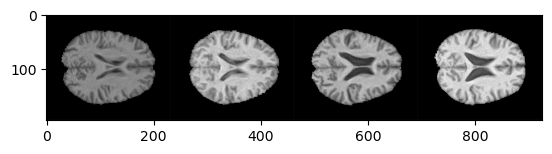

Scores:         4           5           5           11


In [45]:
train_iter = iter(dataloaders['train'])
test_iter = iter(dataloaders['test'])

# get some random training images
images, labels = next(train_iter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print('Scores:        ', '           '.join(f'{int(labels[j])}' for j in range(batch_size)))

### Train

In [7]:
# Define your model and optimizer
model = Net3c2d_bin()
model_name = 'bin_3d2d_3'
model.load_state_dict(torch.load('../models/bin_3d2d_2.pth'))
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Setting up the training
SAVE_PATH = f'../models/{model_name}.pth'
print_every = 1
num_epochs = 50
criterion = nn.MSELoss()

# Early stopping criteria
patience = 10

# train the model
loss_train, loss_val = train_model(model, dataloaders, criterion, optimizer, num_epochs, patience, print_every, SAVE_PATH)

Training model...


Exception ignored in: <function _releaseLock at 0x7f312d7d5cf0>
Traceback (most recent call last):
  File "/home/alex/fsl/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


[1, 0] loss: 58.750


In [8]:

# save the losses
save_losses(model_name, loss_train, loss_val)

# compute the predictions on the test set
test_df = save_test_predictions(model, dataloaders, mtd, csv_path = f'../results/predictions/preds_{model_name}.csv')

# save the parameters
test_loss = get_test_loss(model, dataloaders, criterion)
best_train_loss, best_val_loss = [min(loss_train), min(loss_val)]

accuracy = get_accuracy(test_df)
print(f'Accuracy: {accuracy}')

# calculate the sensitivity and specificity
sensitivity, specificity = get_sensitivity_specificity(test_df)


# Read the csv file called "model_settings.csv" in the "models" folder
csv_path = os.path.join('..', 'models', f'{model_name}.csv')


# if the file does not exist, create it
if not os.path.exists(csv_path):
    df = pd.DataFrame(columns = ['model_name', 'batch_size', 'best_epoch', 'optimizer', 'lr', 'criterion', 'patience',
                                'best_train_loss', 'best_val_loss', 'test_loss', 'accuracy', 'sensitivity', 'specificity', 'precision', 'auc'])
    df.to_csv(csv_path, index = True)
    
df = pd.read_csv(csv_path, index_col = 0)
df.loc[0] = [model_name, batch_size, np.argmax(loss_train), 'Adam', lr, 'MSE', patience, best_train_loss, best_val_loss, test_loss, accuracy, sensitivity, specificity, 'Unknown', 'Unknown']
df.to_csv(csv_path, index = True)


16it [04:13, 15.83s/it]


Accuracy: 0.484375


# Load saved model

In [11]:
net = Net3c2d()

LOAD_PATH = '../models/trial_model_1.pth'
net.load_state_dict(torch.load(LOAD_PATH))

inputs = images.unsqueeze(1).double()
outputs = net(inputs).detach().numpy()

## Predicted values:
"""
NOTE: in prediction of a single value, this is wrong:        _, predicted = torch.max(outputs, 1)
Because ".max()" is giving the class with the highest probability (which is always 0 since there are no classes, only a scalar)
"""

# right way to get the predicted values
predicted = net(inputs).detach().numpy()
labels = labels.detach().numpy()

# print the predicted class
print('Predicted: ', ' '.join(f'{int(predicted[j])}' for j in range(len(predicted))))
print('Labels:    ', ' '.join(f'{int(labels[j])}' for j in range(len(labels))))

Predicted:  9 10 10 10
Labels:     5 11 13 12
